# DECISION TREES

This notebook explores decision tree classification, a powerful machine learning technique for making data-driven decisions. We will build, visualize. and evaluate decision trees using a real-world dataset. This notebook is based on IBM Skill Network's Machine Learning with Python course and the dataset used in this lab is that of Drug Prediction based on health parameters of a patient.

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## About the dataset

Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their of course of treatment, each patient responded to one of 5 medications, Dru A, Drug B, Drug C, Drug X and Drug Y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure and Cholestrol of the patients, and the target is the drug that each patient responded to.

It is a sample of a multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of an unknown patient or to prescribe a drug to a new patient.

## Downloading the data

In [2]:
path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv'
df = pd.read_csv(path)
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


## Data Analysis and Preprocessing

Let us gather some basic information about the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


We can notice that 4 out of 6 features are categorical, which will have to be converted into numerical ones to be used for modelling. To do this, we make use of LabelEncoder from the scikit-learn library.

In [4]:
label_encoder = LabelEncoder()

df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['BP'] = label_encoder.fit_transform(df['BP'])
df['Cholesterol'] = label_encoder.fit_transform(df['Cholesterol'])
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY
...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC
196,16,1,1,0,12.006,drugC
197,52,1,2,0,9.894,drugX
198,23,1,2,1,14.020,drugX


With this, we now have 5 parameters that can be used for modelling and 1 feature as the target variable. We can observe the following mapping after label encoding:
1. For parameter 'Sex': M-1, F-0
2. For parameter 'BP' : High-0, Low-1, Normal-2
3. For parameter 'Cholesterol': High-0, Normal-1

Lets check if there are any missing values in the dataset.

In [5]:
df.isnull().sum()

,0
Age,0
Sex,0
BP,0
Cholesterol,0
Na_to_K,0
Drug,0


There are no missing values in any of the fields.

To evaluate the correlation of the target variable with the input features, it will be convenient to map the different drugs to a numerical value.

In [6]:
custom_map = {'drugA':0,'drugB':1,'drugC':2,'drugX':3,'drugY':4}
df['drug_num'] = df['Drug'].map(custom_map)
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,drug_num
0,23,0,0,0,25.355,drugY,4
1,47,1,1,0,13.093,drugC,2
2,47,1,1,0,10.114,drugC,2
3,28,0,2,0,7.798,drugX,3
4,61,0,1,0,18.043,drugY,4
...,...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC,2
196,16,1,1,0,12.006,drugC,2
197,52,1,2,0,9.894,drugX,3
198,23,1,2,1,14.020,drugX,3


We can now use corr() function to find the correlation of the input variables with the target variable.

In [7]:
df.corr(numeric_only=True)['drug_num']

,drug_num
Age,-0.004828
Sex,-0.098573
BP,0.372868
Cholesterol,0.055629
Na_to_K,0.589120
drug_num,1.000000


We observe that the drug recommendation is mostly correlated with Cholesterol and Na_to_K values.

Lets understand the distribution of the dataset by plotting the count of the records with each drug recommendation.

We can understand the distribution of the dataset by plotting the count of records with each drug recommendation.

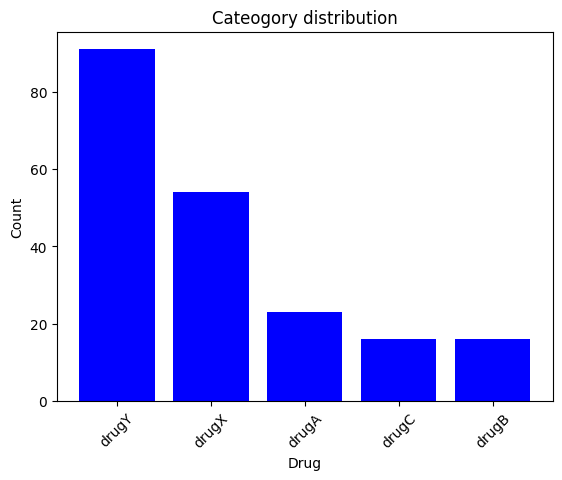

In [8]:
cat_counts = df['Drug'].value_counts()
# print(cat_counts)
#plot the count plot
plt.bar(cat_counts.index,cat_counts.values,color='blue')
plt.xlabel('Drug')
plt.ylabel('Count')
plt.title('Cateogory distribution')
plt.xticks(rotation=45)
plt.show()

This shows us the distribution of the different classes, clearly indicating that Drug X and Drug Y have many more records in comparision to the other 3.

## Modeling

Lets first split the dataset into training and testing subsets.

In [9]:
y = df['Drug']
X = df.drop(['Drug','drug_num'],axis=1)

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=32)

In [11]:
drug_tree = DecisionTreeClassifier(criterion='entropy',max_depth=4)

In [12]:
drug_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

## Evaluation

In [13]:
tree_pred = drug_tree.predict(X_test)

In [17]:
# check the accuracy of our model
print('Acuuracy: ',100*(metrics.accuracy_score(y_test,tree_pred)))

Acuuracy:  98.33333333333333


## Visualize the tree

To understand the classification criteria derived by the decision tree, we can generate the tree plot.

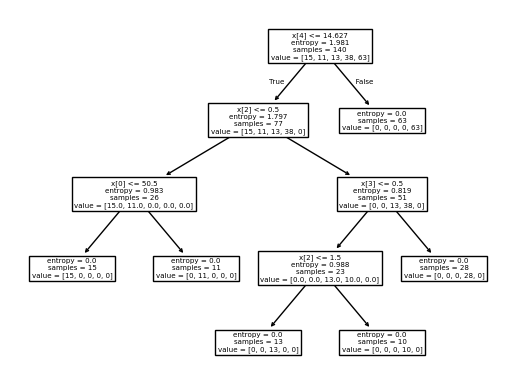

In [18]:
plot_tree(drug_tree)
plt.show()

From this tree, we can derive the criteria developed by the model to identify the class of each training sample. We can interpret them by tracing the criteria defined by tracing down from the root to the tree's leaf nodes. For instance, the decision criterion for Drug Y is Na_to_K > 14.627